In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
from pathlib import Path
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt

from torcheval.metrics import BinaryF1Score, BinaryAccuracy
from torcheval.metrics.functional import binary_accuracy, binary_f1_score
from torch.utils.data.sampler import SubsetRandomSampler
from dgl.dataloading import GraphDataLoader

from src.net import InstanceGCN
from src.utils import load_from_wandb
from src.dataset import InstanceEarlyFixingDataset
from src.problem import load_instance

In [3]:
instances_dir = Path('../data/raw')
instances = [instances_dir/'97_9_9.jl', instances_dir/'97_9_6.jl']

with open('../97_9_opts.pkl', 'rb') as f:
    opts = pickle.load(f)

objs = [opts[i.name]['obj'] for i in instances]
opts = [opts[i.name]['sol'] for i in instances]
ds = InstanceEarlyFixingDataset(
    [load_instance(i) for i in instances],
    opts,
    samples_per_problem=2**9,
)
dl = GraphDataLoader(ds, batch_size=2**5)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-10


In [4]:
net = InstanceGCN(
    2,
    n_passes=1,
    single_conv_for_both_passes=False,
    n_h_feats=19,
    conv1='GraphConv',
    conv2='SAGEConv',
    conv2_kwargs={
        'aggregator_type': 'pool',
        'feat_drop': .09088,
    },
    conv3='GraphConv',
    readout_op=None,
)
net = load_from_wandb(net, 'arrf20uc', 'sat-gnn', 'model_last')
net.eval()

flat_acc = BinaryAccuracy()
flat_f1 = BinaryF1Score()

accs = list()
f1s = list()

outs = list()
hits = list()

net.eval()
with torch.no_grad():
    for X, y in dl:
        y_hat = torch.sigmoid(net(X))
        y_pred = (y_hat>0.5).to(y)

        # outs.append(y_hat.cpu().numpy())
        hits.append(y_pred.cpu().numpy() == y.cpu().numpy())

        for i in range(y.shape[0]):
            accs.append(binary_accuracy(y_hat[i], y[i]))
            f1s.append(binary_f1_score(y_hat[i], y[i]))

        flat_acc.update(y_hat.flatten(), y.flatten())
        flat_f1.update(y_hat.flatten(), y.flatten())
hits = np.concatenate(hits)
flat_acc.compute(), flat_f1.compute()

(tensor(0.8535), tensor(0.8531))

In [8]:
sum(accs[:512]) / 512, sum(accs[512:]) / 512

(tensor(0.8339), tensor(0.8730))

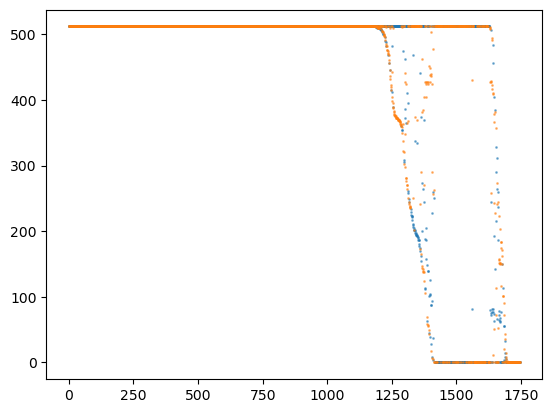

In [63]:
hits1 = hits[:512].sum(axis=0)
hits2 = hits[512:].sum(axis=0)
hs = hits1 + hits2
sort_idx = np.argsort(hs)[::-1]
plt.scatter(list(range(len(hits1))), hits1[sort_idx], s=1, alpha=0.5)
plt.scatter(list(range(len(hits2))), hits2[sort_idx], s=1, alpha=0.5)
plt.show()

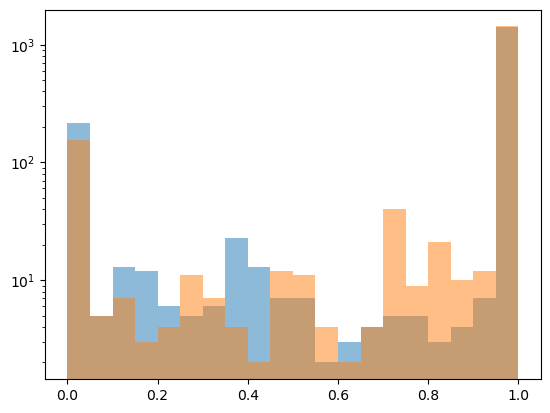

In [67]:
plt.hist(hits1 / 512, bins=20, alpha=0.5)
plt.hist(hits2 / 512, bins=20, alpha=0.5)
plt.yscale('log')
plt.show()

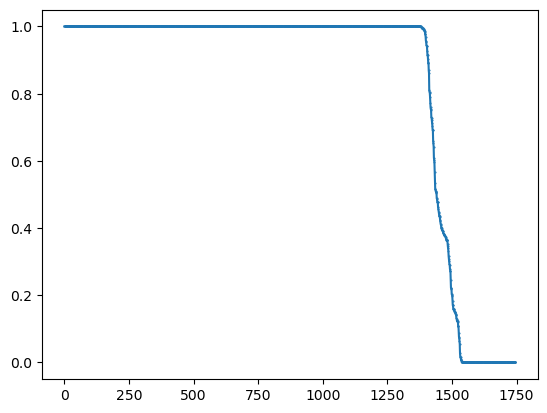

In [46]:
plt.plot(list(range(1746)), sorted(hits[:512].sum(axis=0) / 512, reverse=True), '.-', markersize=1)
# plt.yscale('log')
plt.show()

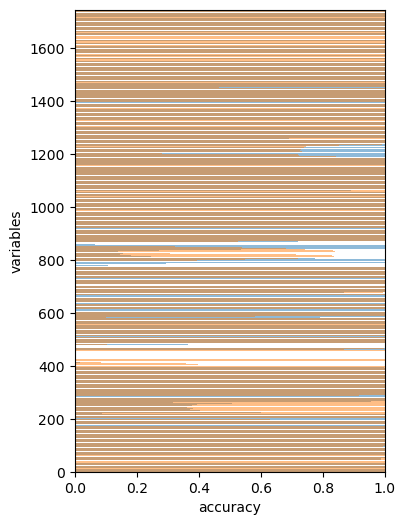

In [79]:
plt.barh(list(range(1746)), hits[:512].sum(axis=0) / 512, alpha=0.5, label='97_9_9')
plt.barh(list(range(1746)), hits[512:].sum(axis=0) / 512, alpha=0.5, label='97_9_6')
plt.gcf().set_size_inches((4,6))
plt.ylim(0,1746)
plt.xlim(0,1)
plt.ylabel('variables')
plt.xlabel('accuracy')
# plt.legend()
# plt.yscale('log')
plt.show()

In [85]:
sum(((hits1 / 512) > 0.99) & ((hits2 / 512) > 0.99))

1208

In [86]:
sum(((hits1 / 512) < 0.01) & ((hits2 / 512) < 0.01))

52

In [29]:
y

tensor([[0, 1, 0,  ..., 1, 1, 0],
        [0, 1, 0,  ..., 0, 1, 0],
        [0, 0, 1,  ..., 1, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 1, 0, 1],
        [0, 1, 1,  ..., 0, 1, 1]])

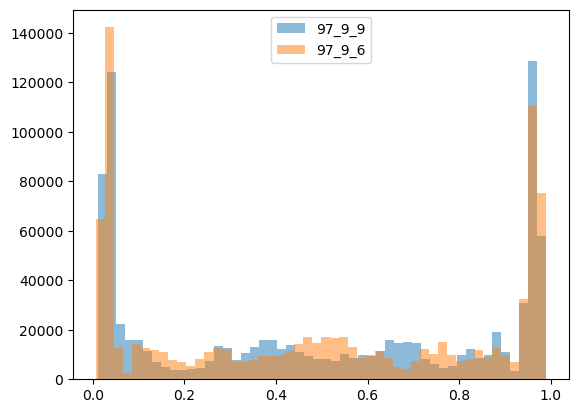

In [10]:
plt.hist(np.concatenate([o.flatten() for o in outs[:16]]), bins=50, label='97_9_9', alpha=0.5)
plt.hist(np.concatenate([o.flatten() for o in outs[16:]]), bins=50, label='97_9_6', alpha=0.5)
plt.legend()
plt.show()

In [36]:
print(np.mean(accs), np.std(accs))
print(np.mean(f1s), np.std(f1s))

0.8535279 0.01969426
0.853132 0.020804971


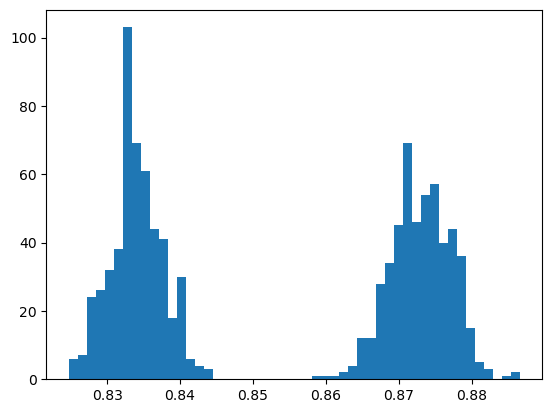

In [29]:
plt.hist(accs, bins=50)
plt.show()

## OOD Generalization

In [6]:
list(Path('../data/raw').glob('120_9*.jl'))  # test instances only

[PosixPath('../data/raw/120_9_5.jl'),
 PosixPath('../data/raw/120_9_3.jl'),
 PosixPath('../data/raw/120_9_1.jl'),
 PosixPath('../data/raw/120_9_2.jl'),
 PosixPath('../data/raw/120_9_4.jl'),
 PosixPath('../data/raw/120_9.jl')]

In [89]:
instances_dir = Path('../data/raw')
instances = [instances_dir/'97_11_5.jl']

opts = dict()
with open('../97_11_opts.pkl', 'rb') as f:
    opts.update(pickle.load(f))

objs = [opts[i.name]['obj'] for i in instances]
opts = [opts[i.name]['sol'] for i in instances]
ds = InstanceEarlyFixingDataset(
    [load_instance(i) for i in instances],
    opts,
    samples_per_problem=2**9,
)
dl = GraphDataLoader(ds, batch_size=2**5)

In [90]:
net = InstanceGCN(
    2,
    n_passes=1,
    single_conv_for_both_passes=False,
    n_h_feats=19,
    conv1='GraphConv',
    conv2='SAGEConv',
    conv2_kwargs={
        'aggregator_type': 'pool',
        'feat_drop': .09088,
    },
    conv3='GraphConv',
    readout_op=None,
)
net = load_from_wandb(net, 'arrf20uc', 'sat-gnn', 'model_last')
net.eval()

flat_acc = BinaryAccuracy()
flat_f1 = BinaryF1Score()

accs = list()
f1s = list()

outs = list()
hits = list()

net.eval()
with torch.no_grad():
    for X, y in dl:
        y_hat = torch.sigmoid(net(X))
        y_pred = (y_hat>0.5).to(y)

        outs.append(y_hat.cpu().numpy())
        hits.append(y_pred.cpu().numpy() == y.cpu().numpy())

        for i in range(y.shape[0]):
            accs.append(binary_accuracy(y_hat[i], y[i]))
            f1s.append(binary_f1_score(y_hat[i], y[i]))

        flat_acc.update(y_hat.flatten(), y.flatten())
        flat_f1.update(y_hat.flatten(), y.flatten())
hits = np.concatenate(hits)
flat_acc.compute(), flat_f1.compute()

(tensor(0.8085), tensor(0.8039))

In [91]:
sum(accs) / len(accs), sum(f1s) / len(f1s)

(tensor(0.8085), tensor(0.8038))

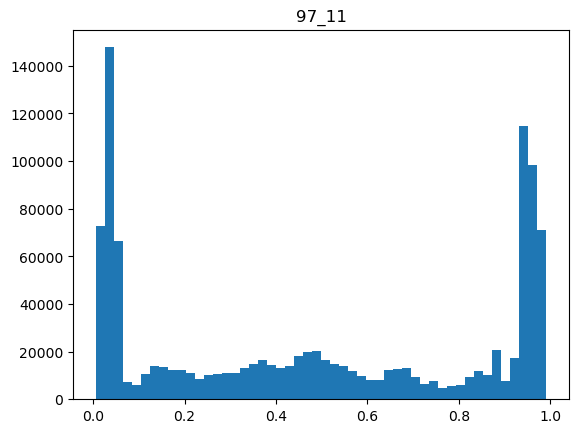

In [92]:
plt.hist(np.concatenate([o.flatten() for o in outs]), bins=50)
plt.title('97_11')
plt.show()

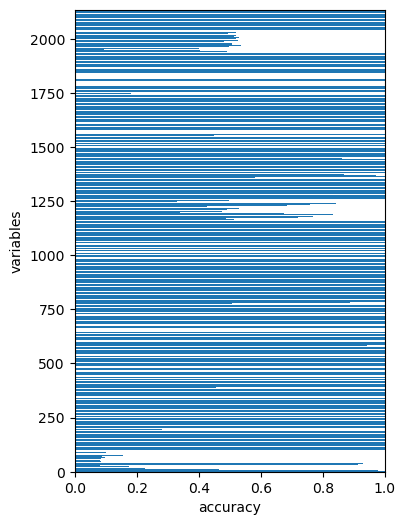

In [93]:
plt.barh(list(range(2134)), hits.sum(axis=0) / 512)
plt.gcf().set_size_inches((4,6))
plt.ylim(0,2134)
plt.xlim(0,1)
plt.ylabel('variables')
plt.xlabel('accuracy')
# plt.legend()
# plt.yscale('log')
plt.show()

In [97]:
sum((hits.sum(axis=0) / 512) > 0.99), sum((hits.sum(axis=0) / 512) < 0.01)

(1556, 227)

In [98]:
instances_dir = Path('../data/raw')
instances = [instances_dir/'120_9.jl']

opts = dict()
with open('../120_9_opts.pkl', 'rb') as f:
    opts.update(pickle.load(f))

objs = [opts[i.name]['obj'] for i in instances]
opts = [opts[i.name]['sol'] for i in instances]
ds = InstanceEarlyFixingDataset(
    [load_instance(i) for i in instances],
    opts,
    samples_per_problem=2**9,
)
dl = GraphDataLoader(ds, batch_size=2**5)

In [99]:
net = InstanceGCN(
    2,
    n_passes=1,
    single_conv_for_both_passes=False,
    n_h_feats=19,
    conv1='GraphConv',
    conv2='SAGEConv',
    conv2_kwargs={
        'aggregator_type': 'pool',
        'feat_drop': .09088,
    },
    conv3='GraphConv',
    readout_op=None,
)
net = load_from_wandb(net, 'arrf20uc', 'sat-gnn', 'model_last')
net.eval()

flat_acc = BinaryAccuracy()
flat_f1 = BinaryF1Score()

accs = list()
f1s = list()

outs = list()
hits = list()

net.eval()
with torch.no_grad():
    for X, y in dl:
        y_hat = torch.sigmoid(net(X))
        y_pred = (y_hat>0.5).to(y)

        outs.append(y_hat.cpu().numpy())
        hits.append(y_pred.cpu().numpy() == y.cpu().numpy())

        for i in range(y.shape[0]):
            accs.append(binary_accuracy(y_hat[i], y[i]))
            f1s.append(binary_f1_score(y_hat[i], y[i]))

        flat_acc.update(y_hat.flatten(), y.flatten())
        flat_f1.update(y_hat.flatten(), y.flatten())
hits = np.concatenate(hits)
flat_acc.compute(), flat_f1.compute()

(tensor(0.7358), tensor(0.7405))

In [100]:
sum(accs) / len(accs), sum(f1s) / len(f1s)

(tensor(0.7358), tensor(0.7404))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


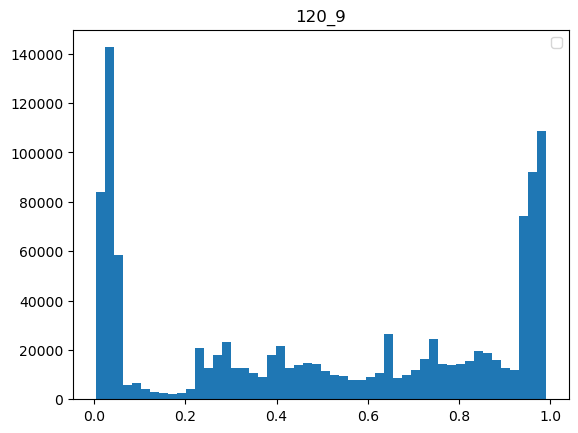

In [101]:
plt.hist(np.concatenate([o.flatten() for o in outs]), bins=50)
plt.title('120_9')
plt.legend()
plt.show()

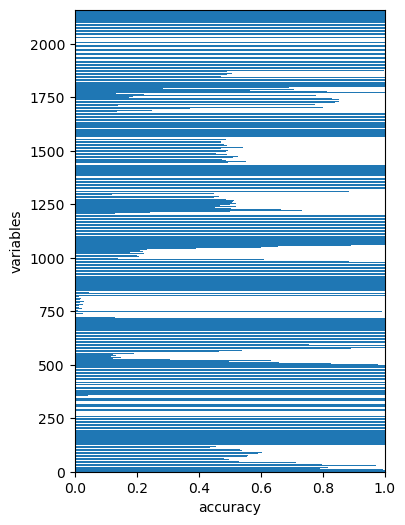

In [102]:
plt.barh(list(range(2160)), hits.sum(axis=0) / 512)
plt.gcf().set_size_inches((4,6))
plt.ylim(0,2160)
plt.xlim(0,1)
plt.ylabel('variables')
plt.xlabel('accuracy')
# plt.legend()
# plt.yscale('log')
plt.show()

In [103]:
sum((hits.sum(axis=0) / 512) > 0.99), sum((hits.sum(axis=0) / 512) < 0.01)

(1230, 178)